# GEODOS data processing

In [27]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from IPython.display import Image as ImageDisp
from pandas import DataFrame
import string
import os
import glob
import matplotlib.pyplot as plt
import glob
import matplotlib
%matplotlib inline

## Read Logfile

In [40]:
dto = '/storage/stations/Kosetice/2023/04/GEODOS'

fto = '/storage/experiments/2022/09_test_geodos/ec/0.TXT'
#fto = '/storage/experiments/2022/09_test_geodos/70/0.TXT'
fto = '/storage/stations/Kosetice/2023/04/GEODOS/45/0.TXT'
#fto = '/storage/experiments/2023/test/0.TXT'


l=[]
l.extend(range(0,1034))
df = pd.read_table(fto, sep=',', header=None, names=l, comment='*',engine='python' )

df.drop(df[df[0]=='$GPTXT'].index, inplace=True)
df.drop(df[df[0]=='$GPVTG'].index, inplace=True)
df.drop(df[df[0]=='$GPGLL'].index, inplace=True)
df.drop(df[df[0]=='$GPGSA'].index, inplace=True)
df.drop(df[df[0]=='$GPGSV'].index, inplace=True)

sn = df.loc[df[0]=='$AIRDOS',3]
fw = df.loc[df[0]=='$AIRDOS',2]
last = df.loc[df[0]=='$AIRDOS'].index
print ('s.n.: ',sn[0])
print ('f.v.: ',fw[0])
print(df.loc[df[0]=='$AIRDOS',1])
print(len(df))
print(last[-1:][0])

# keep only last run
#df.drop(df.index[:last[-1:][0]], inplace=True) 

s.n.:  1290c00806a200921812a000a0000045
f.v.:  NaI(Tl)-D18x30
0         GEO_1024_v4
1         GEO_1024_v4
12        GEO_1024_v4
106224    GEO_1024_v4
212436    GEO_1024_v4
Name: 1, dtype: object
318550
212436


In [29]:
#df = df.iloc[1:]
#df.iloc[-10:,8:]

## Fill position and time (Galileo)

In [30]:
#df.drop(df.loc[(df[0]=='$GNRMC') & (df[2]=='V')].index, inplace=True)
df.loc[(df[0]=='$GNRMC'),'flag']=True
df.loc[(df[0]=='$HIST'),'flag']=False
df.flag = df.flag.fillna(method='ffill')
df['latf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',3])
df['lonf'] = pd.to_numeric(df.loc[df[0]=='$GNRMC',5])
#df.loc[(df[0]=='$TIME') & (df['flag']),'on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
#df['on_miliseconds'] = pd.to_numeric(df.loc[df[0]=='$TIME',1]) * 1000
df['on_miliseconds'] = pd.to_numeric(df.loc[(df[0]=='$TIME') & (df['flag']),1]) * 1000
df['miliseconds'] = pd.to_numeric(df.loc[df[0]=='$HIST',2]) * 1000
df['gps_time'] = df.loc[df[0]=='$GNRMC',1]
df['gps_date'] = df.loc[df[0]=='$GNRMC',9]
df['alt'] = df.loc[df[0]=='$GNGGA',9]
df.loc[(df[0]=='$GNRMC') & (df[6]=='E'),'lon_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[6]=='W'),'lon_hem']=-1
df.loc[(df[0]=='$GNRMC') & (df[4]=='N'),'lat_hem']=1
df.loc[(df[0]=='$GNRMC') & (df[4]=='S'),'lat_hem']=-1
df['lat'] = (np.trunc(df['latf']/100) + (((df['latf']/100) - np.trunc(df['latf']/100)) * 100) / 60.0) * df['lat_hem']
df['lon'] = (np.trunc(df['lonf']/100) + ((df['lonf']/100) - np.trunc(df['lonf']/100)) * 100 / 60.0) * df['lon_hem']  
#df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f')#,errors='coerce')
df['date'] = pd.to_datetime(df['gps_date']+df['gps_time'], format='%d%m%y%H%M%S.%f',errors='coerce')
df.drop('lon_hem', axis=1, inplace=True)
df.drop('lat_hem', axis=1, inplace=True)
df.drop('latf', axis=1, inplace=True)
df.drop('lonf', axis=1, inplace=True)
df.drop('gps_time', axis=1, inplace=True)
df.drop('gps_date', axis=1, inplace=True)
df['meas'] = df.index
#df['meas'] = df.loc[df[0]=='$HIST',1]
df.loc[df[0]=='$HITS','meas'] = np.nan
df.iloc[:,1034:] = df.iloc[:,1034:].fillna(method='ffill')
df.meas = df.meas.astype(int)
df.drop(df[df[0]=='$GPGGA'].index, inplace=True)
df.drop(df[df[0]=='$GNRMC'].index, inplace=True)
df.drop(df[df[0]=='$AIRDOS'].index, inplace=True)
df.drop(df[df[0]=='$TIME'].index, inplace=True)
df['UTC'] = df['date'] + pd.to_timedelta(df['miliseconds'], unit='ms') - pd.to_timedelta(df['on_miliseconds'], unit='ms')
#df.drop('date', axis=1, inplace=True)
#df.drop('miliseconds', axis=1, inplace=True)
#df.drop('on_miliseconds', axis=1, inplace=True)
df.iloc[-10:]

,0,1,2,3,4,5,6,7,8,9,...,1033,flag,on_miliseconds,miliseconds,alt,lat,lon,date,meas,UTC
318636,$HIST,52996,694641.44,944.47,-1.88,2.74,-13,2862,0,34351,...,NaN,False,652544540.0,694641440.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318636,2023-02-10 15:35:17.900
318637,$HITS,2,53883,600,59739,25,None,None,None,None,...,NaN,False,652544540.0,694641440.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318636,2023-02-10 15:35:17.900
318638,$HIST,52997,694654.56,944.46,-1.88,2.74,-13,2884,0,34332,...,NaN,False,652544540.0,694654560.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318638,2023-02-10 15:35:31.020
318639,$HITS,13,7524,27,17036,150,18535,39,19270,37,...,NaN,False,652544540.0,694654560.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318638,2023-02-10 15:35:31.020
318640,$HIST,52998,694667.68,944.50,-1.88,2.74,-13,2901,0,34354,...,NaN,False,652544540.0,694667680.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318640,2023-02-10 15:35:44.140
318641,$HITS,7,1505,539,16660,110,22463,204,43327,797,...,NaN,False,652544540.0,694667680.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318640,2023-02-10 15:35:44.140
318642,$HIST,52999,694680.80,944.45,-1.88,2.74,-13,2917,0,34348,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318643,$HITS,7,11244,70,15763,30,25020,47,51516,52,...,NaN,False,652544540.0,694680800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318642,2023-02-10 15:35:57.260
318644,$HIST,53000,694704.80,944.47,-1.88,2.74,-14,10,1,34347,...,NaN,False,652544540.0,694704800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318644,2023-02-10 15:36:21.260
318645,$HITS,5,6238,57,12716,38,33274,28,58118,608,...,NaN,False,652544540.0,694704800.0,762.1,49.572439,15.080041,2023-02-10 03:53:41,318644,2023-02-10 15:36:21.260


## Add individual events to histogram

In [31]:
HISTHITS = 25 # in version 3, number of channels in $HIST
HISTOGRAM = 8 # the first channel of histogram
FIRSTCH = 4

df.dropna(subset=['UTC'], inplace=True)
hist = df.loc[df[0]=='$HIST'].iloc[:,:HISTOGRAM+HISTHITS].copy()
hist.iloc[:,1:] = hist.iloc[:,1:].apply(pd.to_numeric) #,errors='coerce')
#hist[0] = df[0]
hist['alt'] = df['alt'].apply(pd.to_numeric,errors='coerce')
hist['lat'] = df['lat'].apply(pd.to_numeric,errors='coerce')
hist['lon'] = df['lon'].apply(pd.to_numeric,errors='coerce')
hist['meas'] = df['meas'].apply(pd.to_numeric,errors='coerce')
hist['UTC'] = df['UTC']
#hist.iloc[:,18:269] = 0
hist.set_index('meas', inplace=True)

hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('meas', inplace=True)


In [6]:
#hist.iloc[-10:,7:]

In [32]:
hits.loc[hits[1]>500,1]=500
hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
try:
    durdev = 0
    for i in range(len(hits)):
        for j in range(hits.iloc[i,1]):
            hits.iloc[i,int(1042+hits.iloc[i,j*2+3])] +=1
except:
    print(i,j)
    raise
            
histogram = pd.DataFrame()
histogram = hist.iloc[:,HISTOGRAM+FIRSTCH:HISTOGRAM+HISTHITS]
histogram = histogram.join(hits.iloc[:,1043+HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['UTC'] = hist['UTC']

histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:1024],range(0,1024))})
#histogram.to_csv(dto + '/histogram.csv')
histogram[:5]

/tmp/ipykernel_6875/1170904603.py:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  histogram['temperature'] = hist[4]
/tmp/ipykernel_6875/1170904603.py:16: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  histogram['pressure'] = hist[3]
/tmp/ipykernel_6875/1170904603.py:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe 

,0,1,2,3,4,5,6,7,8,9,...,h1045,h1046,h1047,h1048,h1049,temperature,pressure,voltage,current,UTC
meas,,,,,,,,,,,,,,,,,,,,,
9634,1,2,3,0,2.0,0.0,0.0,1.0,1.0,2.0,...,0,0,0,0,0,-1.88,904.46,2.69,-21,2023-01-18 12:14:52.330
9636,0,0,0,0,0.0,1.0,0.0,1.0,0.0,1.0,...,0,0,0,0,0,-1.88,904.54,2.71,7,2023-01-18 12:15:05.030
9638,0,1,0,0,1.0,0.0,1.0,1.0,0.0,1.0,...,0,0,0,0,0,-1.88,904.53,2.71,38,2023-01-18 12:15:17.720
9640,1,0,3,2,0.0,0.0,3.0,2.0,0.0,0.0,...,0,0,0,0,0,-1.88,904.53,2.71,54,2023-01-18 12:15:30.420
9642,1,1,2,0,2.0,1.0,0.0,0.0,1.0,0.0,...,0,0,0,0,0,-1.88,904.55,2.71,61,2023-01-18 12:15:43.110


In [29]:
histogram.to_csv(dto + '/histogram.csv')

## Variance

/tmp/ipykernel_20319/2650621233.py:10: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = hits.loc['2023-03-31 15:06':'2023-03-31 15:20']


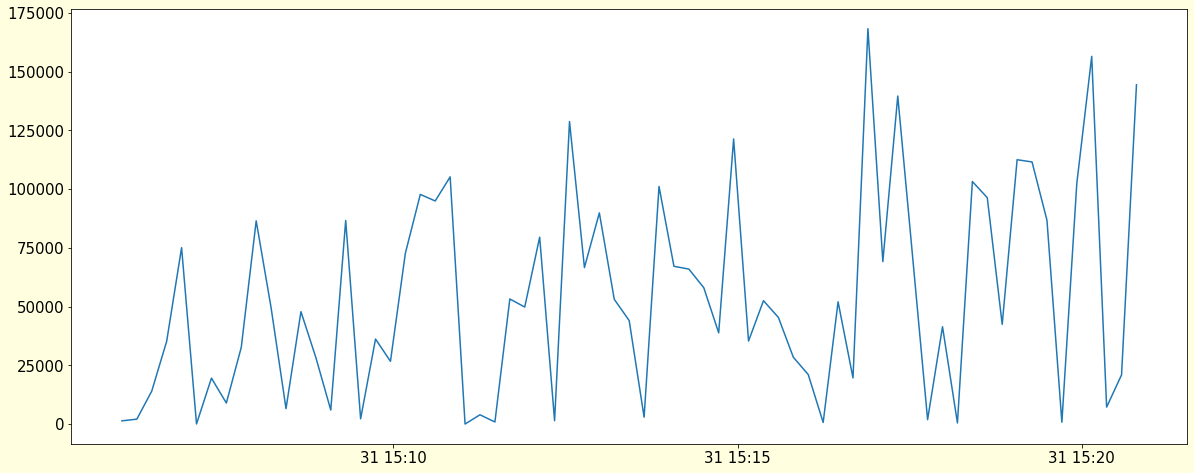

In [180]:
plt.figure(figsize=(20,8), facecolor='lightyellow')
hits = df.loc[df[0]=='$HITS'].copy()
#hits['meas'] = hist.index
hits.iloc[:,1:] = hits.iloc[:,1:].apply(pd.to_numeric)
hits['UTC'] = df['UTC']
hits.set_index('UTC', inplace=True)

#xx = hits.loc['2023-02-01 20:03:00':'2023-02-01 20:04:00']
#xx = hits.loc['2023-02-01 17:00:00':'2023-02-01 22:00:00']
xx = hits.loc['2023-03-31 15:06':'2023-03-31 15:20']

#xx.reset_index(inplace=True, drop=True)
#xx.set_index('UTC', inplace = True, drop=False)
xx['var'] = xx.loc[:,3:1024:2].var(axis=1)


plt.plot(xx.index,xx.loc[:,3:1024:2].var(axis=1))


In [33]:
#df.loc[df['UTC']>'2023-03-31 15:20',1:20]
#df.loc[df['UTC']>'2023-03-31 15:23'].loc[df['UTC']<'2023-03-31 15:25']


## Plot Flux

/tmp/ipykernel_6875/505073307.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_6875/505073307.py:47: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


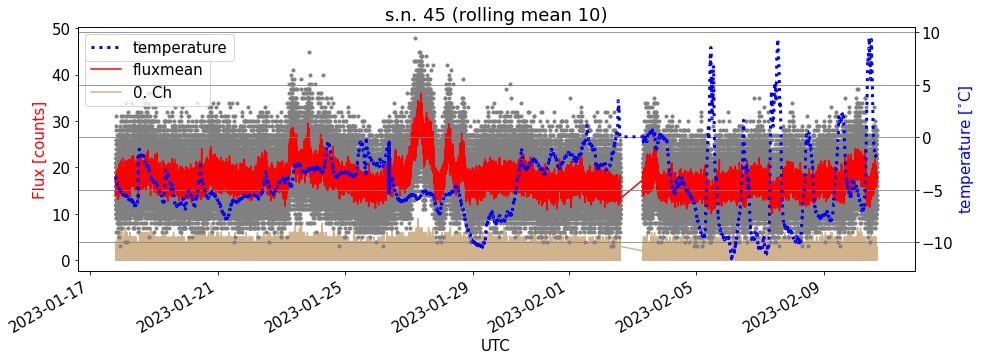

In [34]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2022-1-1 00:00:00':'2022-2-1 00:00:00']
#xx = xx.loc['2022-2-13 00:00:00':'2022-2-22 00:00:00']
#xx = xx.loc['2022-4-25 00:00:00':'2022-4-25 8:00:00']
#xx = xx.loc['2022-1-16 00:00:00':'2022-1-21 00:00:00']
#xx = xx.loc['2021-11-17 00:00:00':'2021-11-18 00:00:00']
#xx = xx.loc['2022-07-17 00:00:00':'2022-07-17 19:50:00']
#xx = xx.loc['2022-07-17 20:00:00':'2022-07-17 23:50:00']
#xx = xx.loc['2023-03-31 15:00':'2023-03-31 15:35']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_32429/1247258885.py:48: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_32429/1247258885.py:49: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


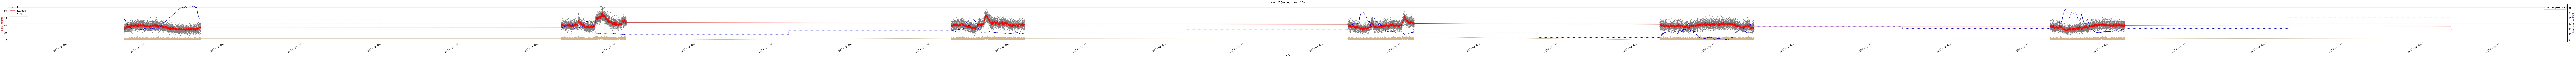

In [7]:
import matplotlib.dates as mdates

NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(300,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2022-1-1 00:00:00':'2022-2-1 00:00:00']
#xx = xx.loc['2022-2-13 00:00:00':'2022-2-22 00:00:00']
#xx = xx.loc['2022-5-19 00:00:00':'2022-5-21 00:00:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')

plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y - %d. %m.'))
plt.gca().xaxis.set_major_locator(mdates.DayLocator())
plt.gcf().autofmt_xdate()

plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()

plt.savefig(dto + '/flux.png')


/tmp/ipykernel_6875/1363537573.py:28: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_6875/1363537573.py:29: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


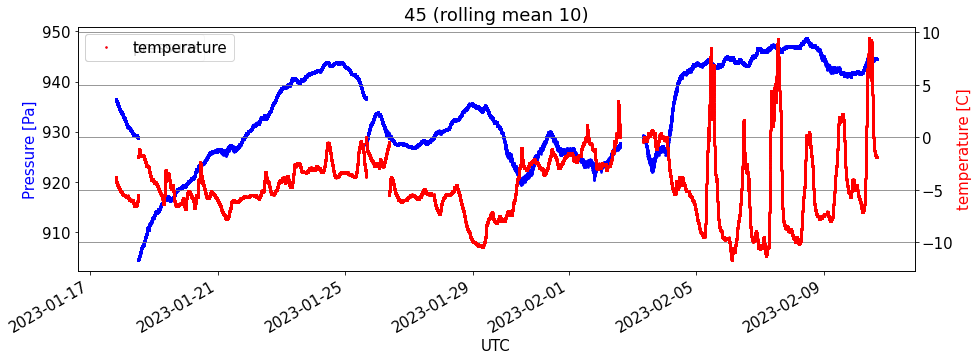

In [35]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']



xx['pressure'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'pressure')

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Pressure [Pa]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('temperature [C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



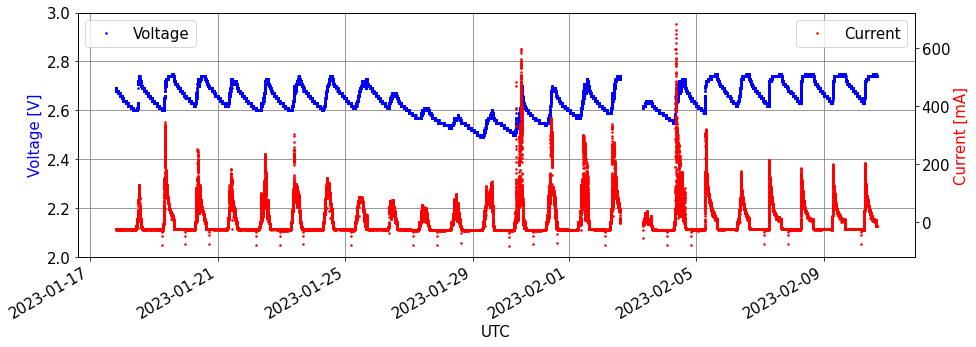

In [36]:
plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2022-10-05 00:00:00':]
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 00:00:00':'2021-08-16 00:00:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']



xx['voltage'].plot(c='blue', linestyle='', marker='.', ms=3, label = 'Voltage')

s = fto.split('/')
#plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
plt.ylim([2,3])
plt.xlabel('UTC')
plt.ylabel(r'Voltage [V]', color='blue')
plt.legend(loc=2)
plt.grid(visible=True, which='major', color='grey', linestyle='-')
plt.grid(visible=True, which='minor', color='grey', linestyle='-')

ax = plt.twinx()

#plt.ylim([0,14000])
xx['current'].plot(c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel('Current [mA]', color='red')

plt.legend()



/tmp/ipykernel_6875/1988575244.py:38: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_6875/1988575244.py:39: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


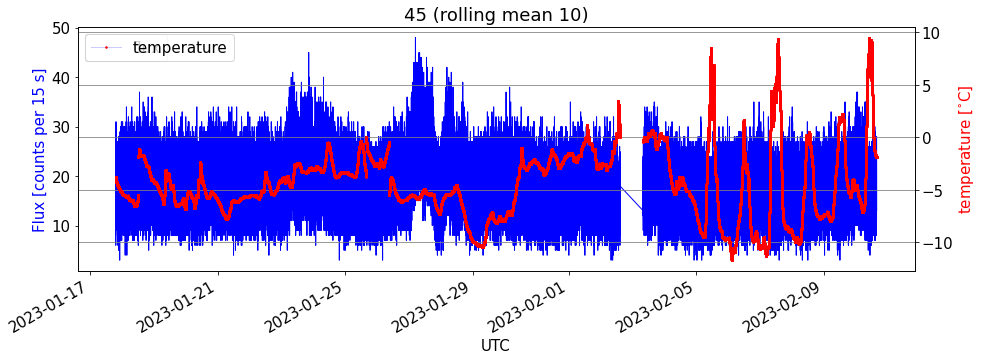

In [37]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})


xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2020-12-04 11:55:00':'2020-12-04 12:20:00']
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

#xx['flux'].plot(c='gray', marker='.', linewidth=1)
xx['flux'].plot(c='blue', linewidth=1)
#xx['fluxmean'].plot(c='red')
#(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title(s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts per 15 s]', color='blue')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='red', label='temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='red')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



# Blitzortung

In [41]:
lat=50.5550792 # Milesovka
lon=13.9316286
start=pd.Timestamp('2021-07-08 16:14')
end=pd.Timestamp('2021-07-08 16:16')
start=pd.Timestamp('2021-07-14 5:14')
end=pd.Timestamp('2021-07-14 5:15')
start=pd.Timestamp('2021-07-17 14:57')
end=pd.Timestamp('2021-07-17 14:58')
start=pd.Timestamp('2021-07-25 17:54')
end=pd.Timestamp('2021-07-25 18:46')
start=pd.Timestamp('2022-02-04 23:00')
end=pd.Timestamp('2022-02-04 23:50')

sitename = 'Kosetice'
lat=49.5722392
lon=15.0799906
start=pd.Timestamp('2023-02-01 20:00')
end=pd.Timestamp('2023-02-01 21:00')
#start=pd.Timestamp('2023-03-30 19:00')
#end=pd.Timestamp('2023-03-30 19:30')
#start=pd.Timestamp('2023-03-31 14:45')
#end=pd.Timestamp('2023-03-31 15:45')

print(start, end, lat, lon)
region=1
region=18
region=19

### url for json data preparation
url=[]

for i in range(0,int(np.ceil((end-start).total_seconds()/600)+1)):
    next=start+ pd.Timedelta(minutes=i*10)
    url.append('http://data.blitzortung.org/Data/Restricted/Strikes_%01d/%02d/%02d/%02d/%02d/%02d.json' % (region, next.year, next.month, next.day, next.hour, np.floor((next.minute)//10)*10))

import requests
blitz=pd.DataFrame()
for i in range(len(url)):
    try:
        html = requests.get(url[i]).content
        blitz_part = pd.read_json(html.decode("utf-8"),lines=True)
        #blitz_part.drop(columns=['status','sig'], inplace=True)#,'region', 
        blitz = pd.concat([blitz,blitz_part])
    except:
        print("No data", url[i])
        pass
blitz.set_index(['time'], inplace=True)

### reduction of too distant events
blitz=blitz[(blitz['lat']>(lat-2) )&(blitz['lat']<(lat+2) )]
blitz=blitz[(blitz['lon']>(lon-3.5) )&(blitz['lon']<(lon+3.5) )]

### calculation of distance of events from station
#from math import radians, cos, sin, asin, sqrt, atan2, degrees
blitz['lonRad']=np.radians(blitz.lon)
blitz['latRad']=np.radians(blitz.lat)
lonRad=np.radians(lon)
latRad=np.radians(lat)
blitz['DlonRad']=lonRad-blitz.lonRad
blitz['DlatRad']=latRad-blitz.latRad
blitz['a']=np.sin(blitz.DlatRad/2.)**2. + np.cos(blitz.latRad) * np.cos(latRad) * np.sin(blitz.DlonRad/2.)**2.
blitz['km'] = 2. * np.arcsin(np.sqrt(blitz.a))*6378.
blitz.drop(columns=['lonRad','latRad','DlonRad','DlatRad','a'], inplace=True)

try:
    blitz.drop(columns=['alt','pol','region'], inplace=True)
except:
    print('No columns to drop (alt, pol, region)')
    pass
#blitz['time']=blitz.index    
blitz['date'] = pd.to_datetime(blitz.index, unit='ns')
blitz.reset_index(inplace=True)
blitz.set_index('date', inplace=True)

blitz.to_csv(dto + "/blitz.csv")

print('end')

2023-02-01 20:00:00 2023-02-01 21:00:00 49.5722392 15.0799906
end


/tmp/ipykernel_6875/1967479397.py:16: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc[FROM:TO]
/tmp/ipykernel_6875/1967479397.py:18: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  blitzblitz = blitz.loc[FROM:TO]
/tmp/ipykernel_6875/1967479397.py:25: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
/tmp/ipykernel_6875/1967479397.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  ax4.grid(b=True, which='major', color='lightgrey', li

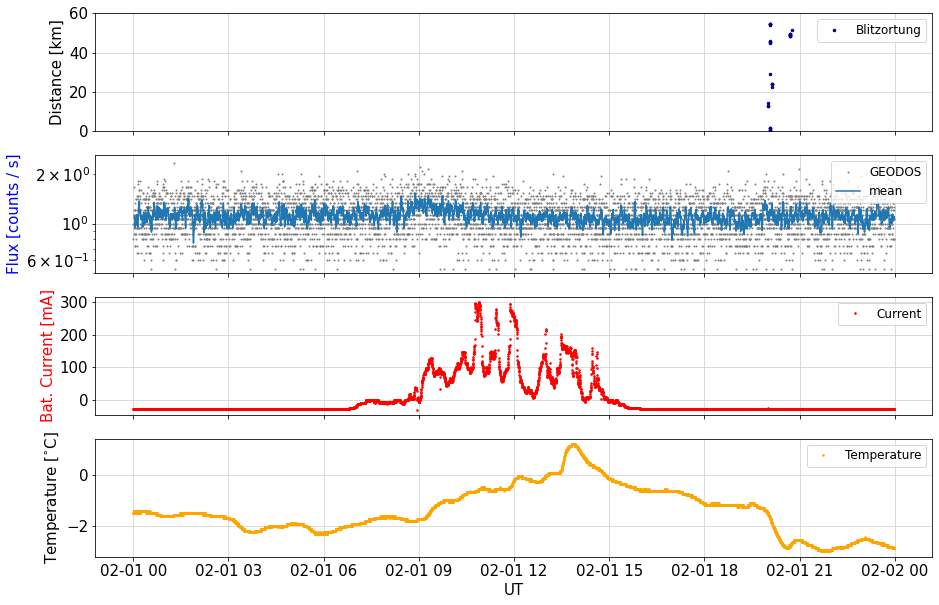

In [43]:
WINDOW = 10

FROM = '2023-02-01 00:00:00'
TO = '2023-02-01 23:59:00'

blitz = pd.read_csv(dto + "/blitz.csv")
blitz['date'] = pd.to_datetime(blitz['date'])
blitz.set_index('date', inplace=True)

fig, (ax6, ax3, ax5, ax4) = plt.subplots(nrows=4, sharex=True, figsize=(15,10))
matplotlib.rcParams.update({'font.size': 12})

xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2021-08-15 12:00:00':'2021-08-16 18:00:00']
xx = xx.loc[FROM:TO]

blitzblitz = blitz.loc[FROM:TO]

xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

ax3.plot(xx['flux']/15, marker='.', color='gray', label='GEODOS', ms=2, linestyle='none')
ax3.plot(xx['fluxmean']/15, label='mean')
ax3.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax3.set_ylabel(r'Flux [counts / s]', color='blue')
ax3.set_yscale('log')
ax3.set_ylim(0.5,)
ax3.legend()

ax4.plot(xx['temperature'], c='orange', label='Temperature', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax4.set_xlabel('UT')
ax4.set_ylabel(r'Temperature [$^{\circ}$C]')
ax4.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax4.legend()

ax6.plot(blitzblitz.index, blitzblitz.km, ls='', marker='.', ms=5, label='Blitzortung', c='darkblue')
ax6.set_ylabel('Distance [km]')
ax6.legend()
ax6.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax6.set_ylim(0,60)

ax5.plot(xx['current'], c='red', label='Current', marker='.', ms=3, linewidth='1', linestyle='none', drawstyle='steps-mid')
ax5.set_ylabel('Bat. Current [mA]', color='red')
ax5.grid(b=True, which='major', color='lightgrey', linestyle='-')
ax5.legend()


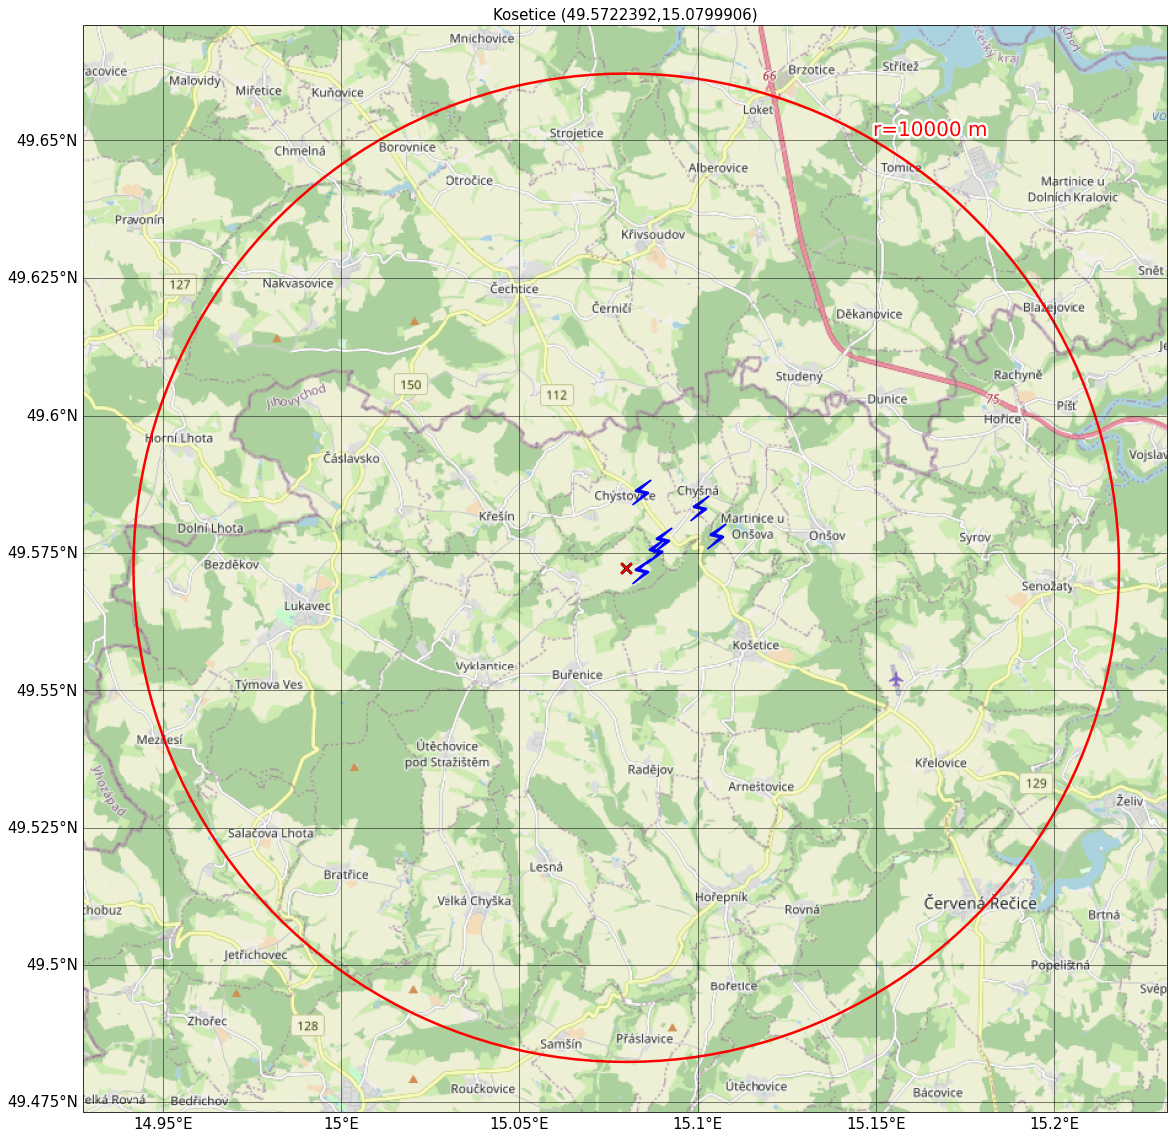

In [42]:
__title__   = 'Plot OpenStreetMap site map'
__version__ = 'v1.0 (2021-03-02)'
__author__  = 'Mathew Lipson'
__email__   = 'm.lipson@unsw.edu.au'

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.patheffects as pe
import cartopy
import cartopy.geodesic as cgeo
import cartopy.crs as ccrs

import cartopy.io.img_tiles as cimgt
import io
from urllib.request import urlopen, Request
from PIL import Image
import shapely

projpath = '.'

##########################################################################

def main():

    sitename = 'Polednik'
    lat = 49.063936
    lon = 13.395348
    #lat = 49.5
    #lon = 14.3
    sitename = 'Kosetice'
    lat=49.5722392
    lon=15.0799906
        
    RADIUS = 10000
    
    # style can be 'map' or 'satellite'

    #for style in ['map','satellite']:

    osm_image(lon, lat, sitename=sitename, style='map', radius=RADIUS)

    return

##########################################################################

def osm_image(lon,lat,sitename='Columbo',style='satellite',radius=500):
    '''This function makes OpenStreetMap satellite or map image with circle and random points.
    Change np.random.seed() number to produce different (reproducable) random patterns of points.
    Also review 'scale' variable'''

    if style=='map':
        ## MAP STYLE
        cimgt.OSM.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.OSM() # spoofed, downloaded street map
    elif style =='satellite':
        # SATELLITE STYLE
        cimgt.QuadtreeTiles.get_image = image_spoof # reformat web request for street map spoofing
        img = cimgt.QuadtreeTiles() # spoofed, downloaded street map
    else:
        print('no valid style')

    stroke = [pe.Stroke(linewidth=1, foreground='w'), pe.Normal()]

    ############################################################################

    plt.close('all')
    fig = plt.figure(figsize=(20,20)) # open matplotlib figure
    ax = plt.axes(projection=img.crs) # project using coordinate reference system (CRS) of street map
    data_crs = ccrs.PlateCarree()

    ax.set_title(f'{sitename} ({lat},{lon})',fontsize=15)

    # auto-calculate scale
    #scale = int(120/np.log(radius))
    scale = int(115/np.log(radius))
    scale = (scale<20) and scale or 19

    # or change scale manually
    # NOTE: scale specifications should be selected based on radius
    # but be careful not have both large scale (>16) and large radius (>1000), 
    #  it is forbidden under [OSM policies](https://operations.osmfoundation.org/policies/tiles/)
    # -- 2     = coarse image, select for worldwide or continental scales
    # -- 4-6   = medium coarseness, select for countries and larger states
    # -- 6-10  = medium fineness, select for smaller states, regions, and cities
    # -- 10-12 = fine image, select for city boundaries and zip codes
    # -- 14+   = extremely fine image, select for roads, blocks, buildings

    extent = calc_extent(lon,lat,radius*1.1)
    ax.set_extent(extent) # set extents
    ax.add_image(img, int(scale)) # add OSM with zoom specification

    # add site
    ax.plot(lon,lat, color='black', marker='x', ms=10, mew=3, transform=data_crs)
    ax.plot(lon,lat, color='red', marker='x', ms=11, mew=2, transform=data_crs)

    #lightning = blitz.loc['2021-08-15 16:00:00':'2021-08-15 20:00:00']
    lightning = blitz
    #lightning = blitz.loc['2021-08-16 10:00:00':'2021-08-16 12:00:00']
    #ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u21AF$',ms=25,mew=1.0,transform=data_crs)
    #ax.plot(lightning.lon,lightning.lat,color='black',lw=0,marker='$\u26A1$',ms=35,mew=1.0,transform=data_crs)
    ax.plot(lightning.lon,lightning.lat,color='blue',lw=0,marker='$\u26A1$',ms=25,mew=1.0,transform=data_crs)

    # Cas jednotlivych bodu
    #for index, row in lightning.iterrows():
    #    ax.text(row.lon, row.lat, row.UTC, color='red', fontsize=10, ha='left',va='bottom', transform=data_crs)


    # add cartopy geodesic circle
    circle_points = cgeo.Geodesic().circle(lon=lon, lat=lat, radius=radius)
    geom = shapely.geometry.Polygon(circle_points)
    ax.add_geometries((geom,), crs=ccrs.PlateCarree(), edgecolor='red', facecolor='none', linewidth=2.5)

    radius_text = cgeo.Geodesic().direct(points=(lon,lat),azimuths=30,distances=radius)[:,0:2][0]
    stroke = [pe.Stroke(linewidth=5, foreground='w'), pe.Normal()]
    ax.text(radius_text[0],radius_text[1],f'r={radius} m', color='red', 
        fontsize=20, ha='left',va='bottom', path_effects=stroke, transform=data_crs)

    gl = ax.gridlines(draw_labels=True, crs=data_crs,
                        color='k',lw=0.5)

    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = cartopy.mpl.gridliner.LONGITUDE_FORMATTER
    gl.yformatter = cartopy.mpl.gridliner.LATITUDE_FORMATTER

    plt.show()

    #fig.savefig(f'{projpath}/{sitename}_{style}_r{radius}_pts{npoints}_scale{scale}.jpg', dpi=150, bbox_inches='tight')

    return

def calc_extent(lon,lat,dist):
    '''This function calculates extent of map
    Inputs:
        lat,lon: location in degrees
        dist: dist to edge from centre
    '''

    dist_cnr = np.sqrt(2*dist**2)
    top_left = cgeo.Geodesic().direct(points=(lon,lat),azimuths=-45,distances=dist_cnr)[:,0:2][0]
    bot_right = cgeo.Geodesic().direct(points=(lon,lat),azimuths=135,distances=dist_cnr)[:,0:2][0]

    extent = [top_left[0], bot_right[0], bot_right[1], top_left[1]]

    return extent

def image_spoof(self, tile):
    '''this function reformats web requests from OSM for cartopy
    Heavily based on code by Joshua Hrisko at:
        https://makersportal.com/blog/2020/4/24/geographic-visualizations-in-python-with-cartopy'''

    url = self._image_url(tile)                # get the url of the street map API
    req = Request(url)                         # start request
    req.add_header('User-agent','Anaconda 3')  # add user agent to request
    fh = urlopen(req) 
    im_data = io.BytesIO(fh.read())            # get image
    fh.close()                                 # close url
    img = Image.open(im_data)                  # open image with PIL
    img = img.convert(self.desired_tile_form)  # set image format
    return img, self.tileextent(tile), 'lower' # reformat for cartopy

if __name__ == "__main__":

   main()

# Energy Spectrum

/tmp/ipykernel_6875/2627665806.py:5: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-02-01 00:00:00':'2023-02-01 23:59:00']
/tmp/ipykernel_6875/2627665806.py:18: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,2e4])


(0.6418055466599409, 20000.0)

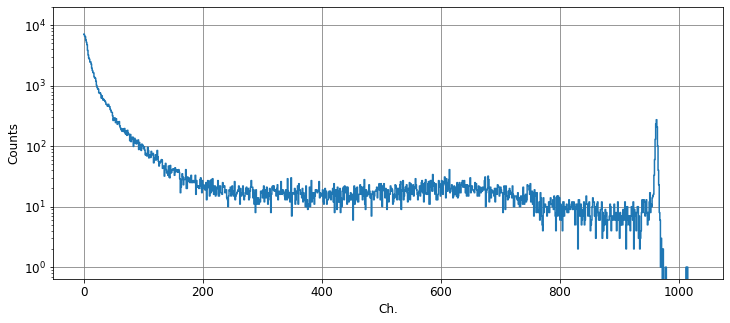

In [44]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2022-10-06 00:00:00':]
yy = yy.loc['2023-02-01 00:00:00':'2023-02-01 23:59:00']

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
#plt.xlim([32,280])
plt.ylim([0,2e4])

/tmp/ipykernel_6875/661695906.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  yy = yy.loc['2023-02-01 20:00:00':]


(0.0, 20.0)

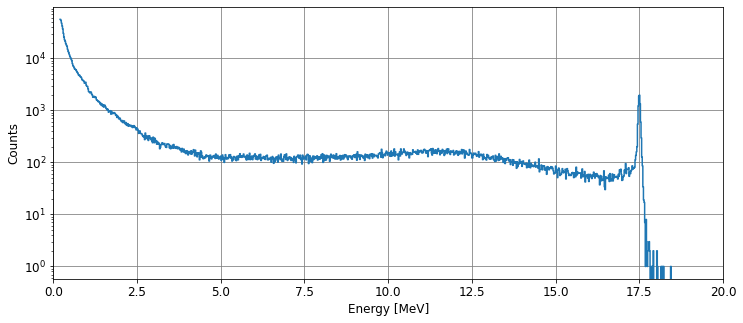

In [21]:
yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc['2023-02-01 20:00:00':]
#yy = yy.loc['2021-05-12 13:58:00':'2021-05-12 14:20:00']

#yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:1024],range(0,1024))})
ener = yy.iloc[:,1:1024].sum()
ener = ener.reset_index()
ener['ener'] = 0.018 * ener.index + 0.2

plt.figure(figsize=(12,5))
plt.plot(ener['ener'], ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Energy [MeV]')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,20])
#plt.ylim([0,250])

In [22]:
ener['ener'] = 0.015 * ener.index + 0.268 


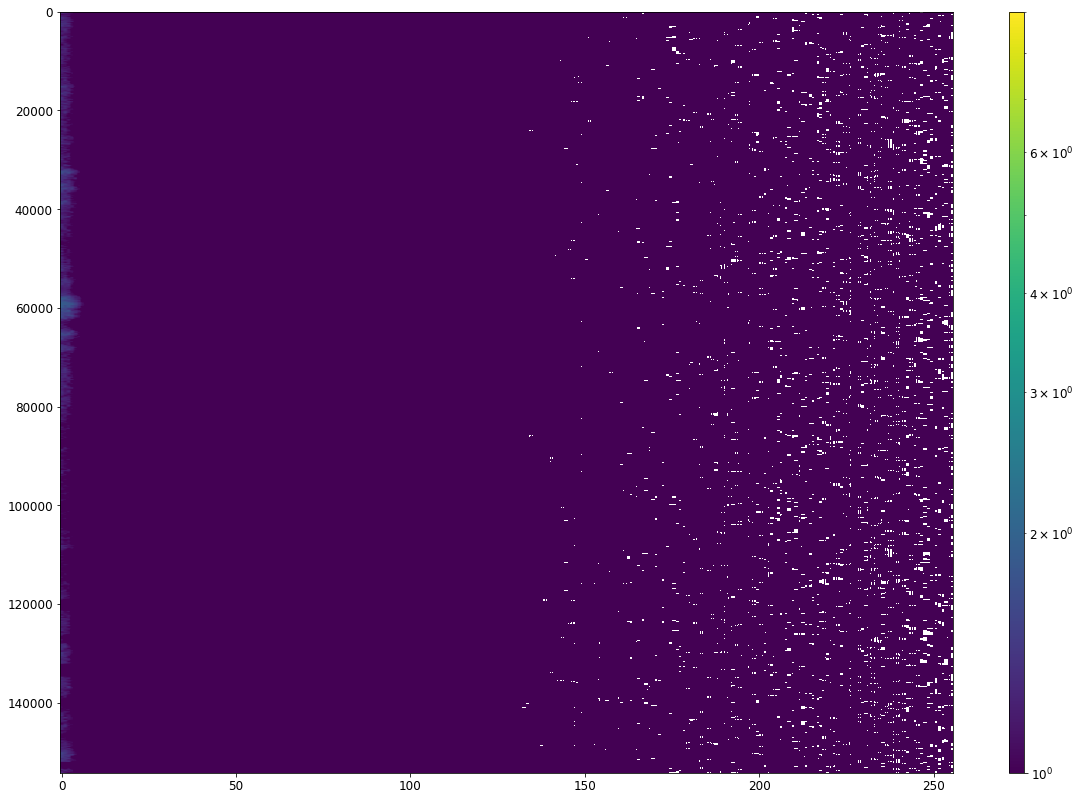

In [23]:
from matplotlib.colors import LogNorm

plt.figure(figsize=(20, 14))
plt.imshow((histogram.iloc[:,0:256]), aspect='auto', norm=LogNorm())
plt.colorbar(aspect=50)
None

/tmp/ipykernel_6875/4090771077.py:44: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_6875/4090771077.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


(0.0, 30.0)

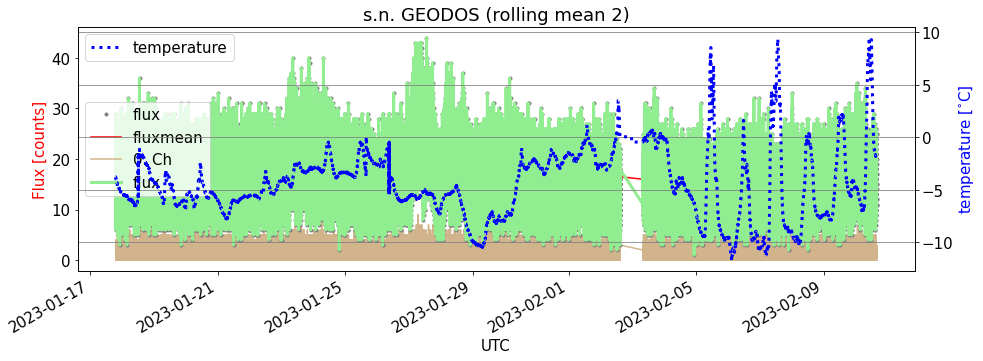

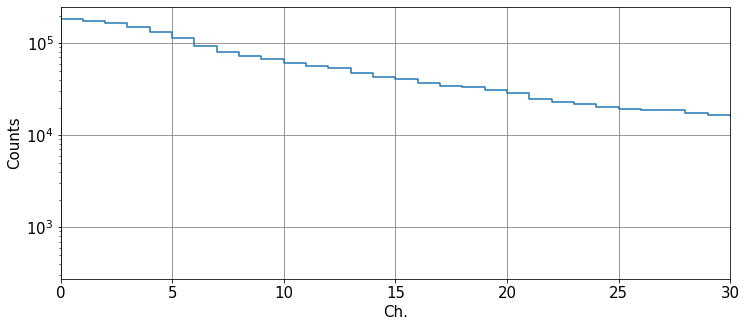

In [24]:
NOISE_LEVEL = 0
LAST_CHANNEL = 256
WINDOW = 2

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2021-05-12 8:35:00':'2021-05-12 16:00:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))
#yy = xx.loc['2021-05-12 11:05:00':'2021-05-12 11:30:00']
#yy = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
yy = xx

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)
yy['flux'].plot(c='lightgreen', linewidth='3')

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,1.5])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=6)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()

yy = yy.rename(columns={x:y for x,y in zip(yy.columns[:258],range(0,258))})
ener = yy.iloc[:,0:240].sum()
ener = ener.reset_index()
plt.figure(figsize=(12,5))
plt.plot(ener[0], drawstyle='steps-post')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([0,30])

In [25]:
l = np.array([[1, 1],[5,1]]) # Calibration
r = np.array([0.511, 1.275])
coef = np.linalg.solve(l,r)
print (coef[0], coef[1])
255  * coef[0] + coef[1]

0.19099999999999998 0.32


49.02499999999999

In [26]:
raise # nedodelano

hits.loc[hits[1]>500,1]=500
hits.loc[:,[*map('h{:04}'.format, range(1050))]] = 0
            
nchannels = 1024

try:
    for i in range(len(hits)):
        nevents = hits.iloc[i,1]
        events_chan = hits.iloc[i,3::2][:nevents]
        hits.iloc[i,1042:1042+nchannels] = np.bincount(events_chan, minlength=nchannels)
except:
    print(i)
    raise
    
histogram = pd.DataFrame()
histogram = hist.iloc[:,10+FIRSTCH:10+HISTHITS]
histogram = histogram.join(hits.iloc[:,1042+HISTHITS:])
histogram['temperature'] = hist[4]
histogram['pressure'] = hist[3]
histogram['voltage'] = hist[5]
histogram['current'] = hist[6]
histogram['UTC'] = hist['UTC']
histogram = histogram.rename(columns={x:y for x,y in zip(histogram.columns[:1024],range(0,1024))})
#histogram.to_csv(dto + '/histogram.csv')
histogram

RuntimeError: No active exception to reraise

/tmp/ipykernel_20319/952035848.py:18: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  xx = xx.loc['2023-03-31 15:00':'2023-03-31 15:35']
/tmp/ipykernel_20319/952035848.py:43: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_20319/952035848.py:44: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


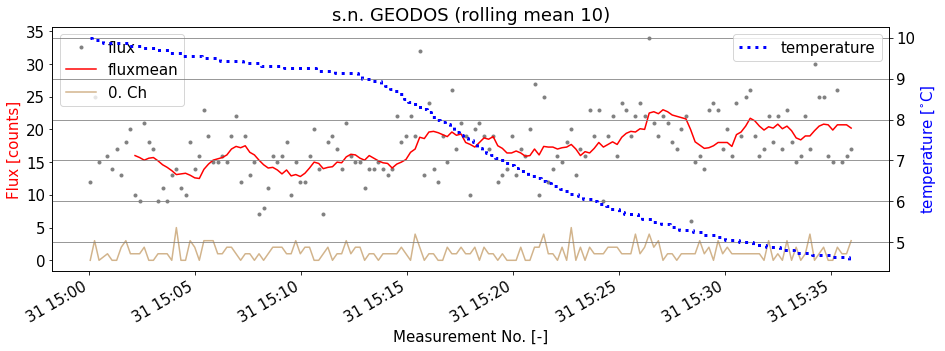

In [160]:
NOISE_LEVEL = 0
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2023-02-01 00:00:00':'2023-02-02 23:59:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2022-1-1 00:00:00':'2022-2-1 00:00:00']
#xx = xx.loc['2022-2-13 00:00:00':'2022-2-22 00:00:00']
#xx = xx.loc['2023-03-08 00:00:00':'2023-03-09 23:59:00']
xx = xx.loc['2023-03-31 15:00':'2023-03-31 15:35']


#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('Measurement No. [-]')
plt.ylabel(r'Flux [counts]', color='red')
plt.legend(loc=2)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-mid')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()



/tmp/ipykernel_25698/992775256.py:17: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,2e4])
/tmp/ipykernel_25698/992775256.py:33: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  plt.ylim([0,2e4])


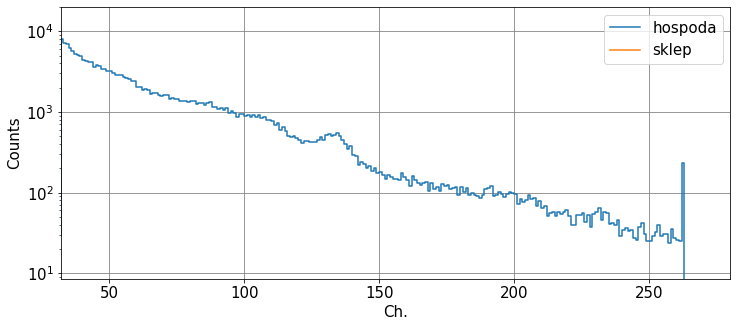

In [9]:
plt.figure(figsize=(12,5))

yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

#yy = yy.loc['2022-07-17 00:00:00':'2022-07-17 19:50:00']

ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
plt.plot(ener[0], drawstyle='steps-post', label='hospoda')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([32,280])
plt.ylim([0,2e4])

yy = histogram.copy()
yy.set_index('UTC', inplace = True, drop=False)

yy = yy.loc['2022-07-17 20:00:00':'2022-07-18 22:50:00']

ener = yy.iloc[:,0:1024].sum()
ener = ener.reset_index()
plt.plot(ener[0], drawstyle='steps-post', label='sklep')
plt.yscale('log')
plt.xlabel('Ch.')
plt.ylabel('Counts')
#plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(color='grey')
plt.xlim([32,280])
plt.ylim([0,2e4])

plt.legend()

/tmp/ipykernel_8871/4012391210.py:45: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='grey', linestyle='-')
/tmp/ipykernel_8871/4012391210.py:46: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='minor', color='grey', linestyle='-')


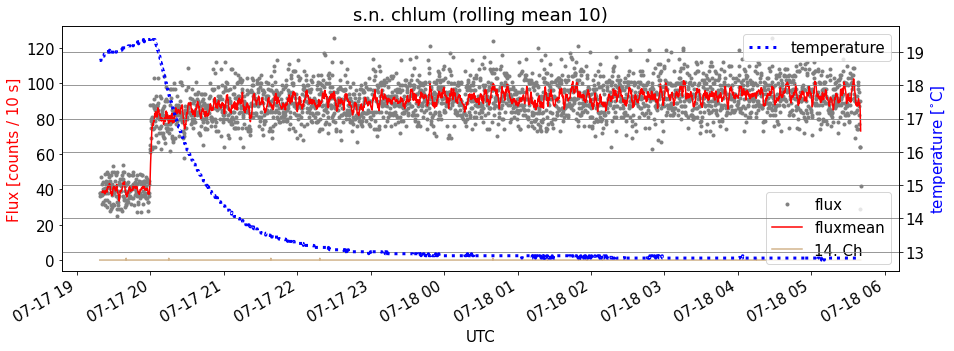

In [25]:
NOISE_LEVEL = 14
LAST_CHANNEL = 1023
WINDOW = 10

plt.figure(figsize=(15,5))
plt.tight_layout()
matplotlib.rcParams.update({'font.size': 15})

#histogram.read_csv(dto + '/histogram.csv')
xx = histogram.copy()
xx.set_index('UTC', inplace = True, drop=False)
#xx = xx.loc['2019-11-27 00:00:00':'2019-11-29 01:30:00']
#xx = xx.loc['2021-08-15 17:45:00':'2021-08-15 18:40:00']
#xx = xx.loc['2021-11-30 12:35:00':'2021-11-30 12:45:00']
#xx = xx.loc['2022-1-1 00:00:00':'2022-2-1 00:00:00']
#xx = xx.loc['2022-2-13 00:00:00':'2022-2-22 00:00:00']
#xx = xx.loc['2022-4-25 00:00:00':'2022-4-25 8:00:00']
#xx = xx.loc['2022-1-16 00:00:00':'2022-1-21 00:00:00']
#xx = xx.loc['2021-11-17 00:00:00':'2021-11-18 00:00:00']
#xx = xx.loc['2022-07-17 00:00:00':'2022-07-17 19:50:00']
#xx = xx.loc['2022-07-17 20:00:00':'2022-07-17 23:50:00']

#plt.yscale('log')
xx['flux'] = (xx.iloc[:,range(NOISE_LEVEL,LAST_CHANNEL)].sum(axis=1))

xx['fluxmean'] = xx['flux'].rolling(WINDOW).mean()

xx['flux'].plot(c='gray', linestyle='', marker='.')
xx['fluxmean'].plot(c='red')
(xx.iloc[:,NOISE_LEVEL]).plot(c='tan',label= str(NOISE_LEVEL) + '. Ch' ,zorder=1)

s = fto.split('/')
plt.title("s.n. " + s[len(s)-2] + ' (rolling mean ' + str(WINDOW) + ')')
#plt.ylim([0,350])
plt.xlabel('UTC')
plt.ylabel(r'Flux [counts / 10 s]', color='red')
plt.legend(loc=4)

ax = plt.twinx()

#plt.ylim([0,14000])
xx['temperature'].plot(c='blue', label='temperature', linewidth='3', linestyle=':', drawstyle='steps-post')
plt.ylabel(r'temperature [$^{\circ}$C]', color='blue')

plt.grid(b=True, which='major', color='grey', linestyle='-')
plt.grid(b=True, which='minor', color='grey', linestyle='-')
plt.legend()

